# Analyze Patient Visit Data from an Outpatient Clinic Using Python




## Import Libraries and Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from prophet import Prophet

In [ ]:
df_visits = pd.read_csv('/content/Demo Hospital Outpatient Data_NHC.csv')

## Exploratory Data Analysis

In [ ]:
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Visit_Date     1000000 non-null  object 
 1   Patient_ID     1000000 non-null  int64  
 2   Age            1000000 non-null  int64  
 3   Gender         1000000 non-null  object 
 4   Diagnosis      1000000 non-null  object 
 5   Has_Insurance  1000000 non-null  bool   
 6   Postcode       1000000 non-null  int64  
 7   Total_Cost     1000000 non-null  float64
 8   Registration   1000000 non-null  int64  
 9   Nursing        1000000 non-null  int64  
 10  Laboratory     1000000 non-null  int64  
 11  Consultation   1000000 non-null  int64  
 12  Pharmacy       1000000 non-null  int64  
dtypes: bool(1), float64(1), int64(8), object(3)
memory usage: 92.5+ MB


In [ ]:
df_visits.isna().sum()

,0
Visit_Date,0
Patient_ID,0
Age,0
Gender,0
Diagnosis,0
Has_Insurance,0
Postcode,0
Total_Cost,0
Registration,0
Nursing,0


In [ ]:
df_visits = df_visits.dropna()

In [ ]:
columns_mapping = {'Nursing':'Nursing_Minutes', 'Laboratory':'Laboratory_Minutes',
                   'Consultation':'Consultation_Minutes',
                   'Pharmacy':'Pharmacy_Minutes','Registration':'Registration_Minutes'}

df_visits.rename(columns=columns_mapping,inplace=True)

### Demographic Analysis of Patient

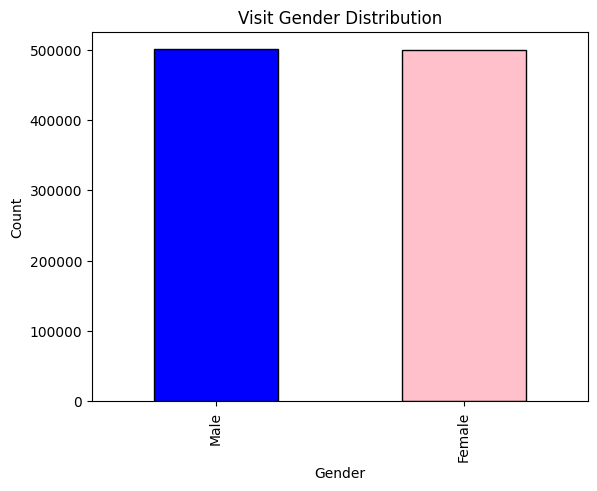

In [ ]:
visits_gender = df_visits['Gender'].value_counts()
visits_gender.plot(kind='bar',color=['blue','pink'],edgecolor='k')
plt.title('Visit Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

Patient visit patterns do not show a significant variation based on gender.



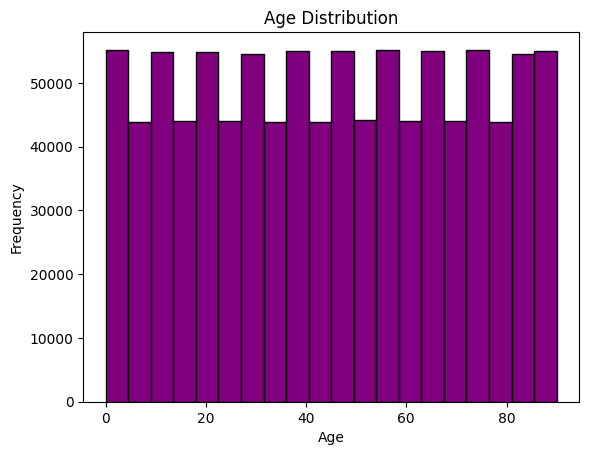

In [ ]:
plt.hist(df_visits['Age'], bins=20, color='purple', edgecolor='k')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

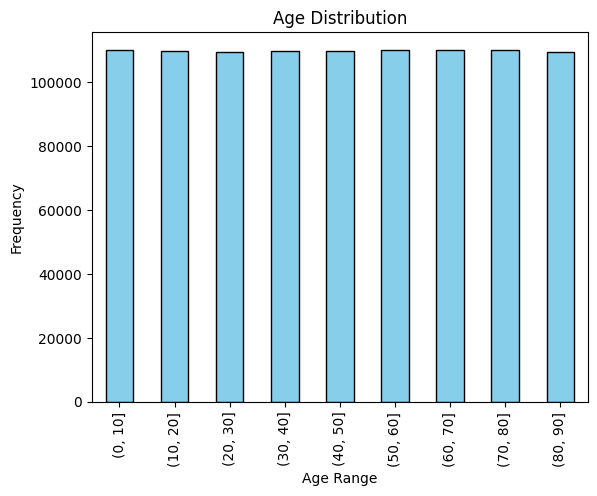

In [ ]:
age_bins = [0,10,20,30,40,50,60,70,80,90]
df_visits['Age_Range'] = pd.cut(df_visits['Age'], bins=age_bins)
age_distribution = df_visits['Age_Range'].value_counts().sort_index()

age_distribution.plot(kind='bar', color='skyblue', edgecolor='k')
plt.title('Age Distribution')
plt.xlabel('Age Range')
plt.ylabel('Frequency')
plt.show()

Patient visit patterns do not show a significant variation based on age range.

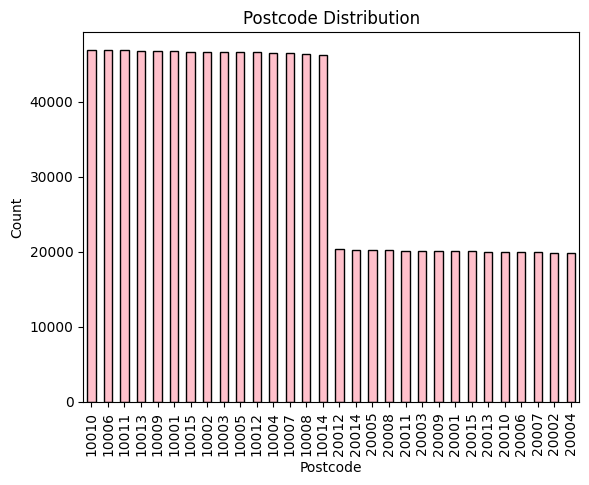

In [ ]:
postcode_count = df_visits['Postcode'].value_counts()
figsize = (8,5)
postcode_count.plot(kind='bar', color='pink',edgecolor='k')
plt.title('Postcode Distribution')
plt.xlabel('Postcode')
plt.ylabel('Count')
plt.show()

Patient visit patterns show a significant increase from certain postcodes.

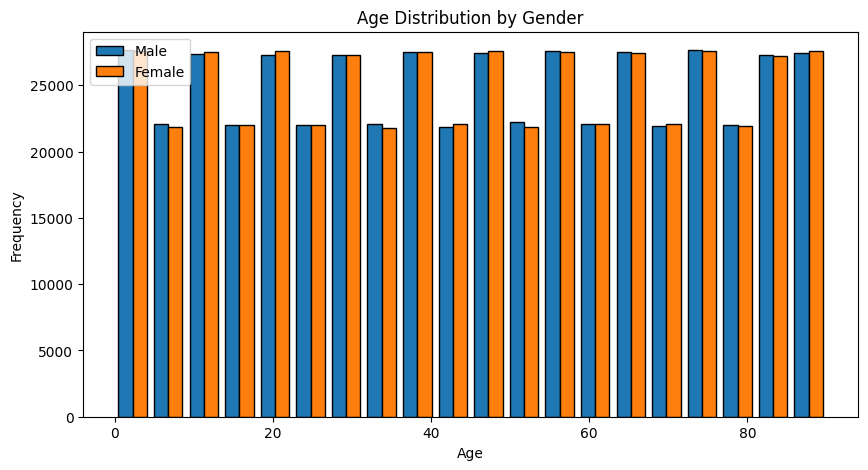

In [ ]:
plt.figure(figsize=(10,5))
plt.hist([df_visits[df_visits['Gender']=='Male']['Age'],
         df_visits[df_visits['Gender']=='Female']['Age']],
         bins=20, label=['Male','Female'],
         edgecolor='k')
plt.title('Age Distribution by Gender')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

There is an increase in the frequency of patient visits among females aged 50.

### Trend Analysis of Patient Visit

In [ ]:
df_visits['Visit_Date'] = pd.to_datetime(df_visits['Visit_Date'])

In [ ]:
df_visits.set_index('Visit_Date', inplace=True)

In [ ]:
df_resampled_year = df_visits.resample('YE').count()

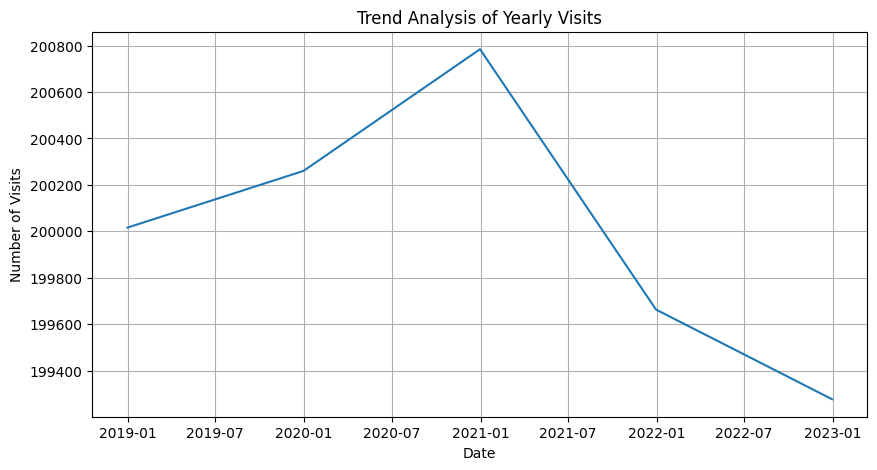

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_resampled_year.index, df_resampled_year['Patient_ID'])
plt.title('Trend Analysis of Yearly Visits')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.grid()
plt.show()

Patient visit frequency peaked around 2020, followed by a decline in 2021.

In [ ]:
df_resampled_month = df_visits.resample('ME').count()

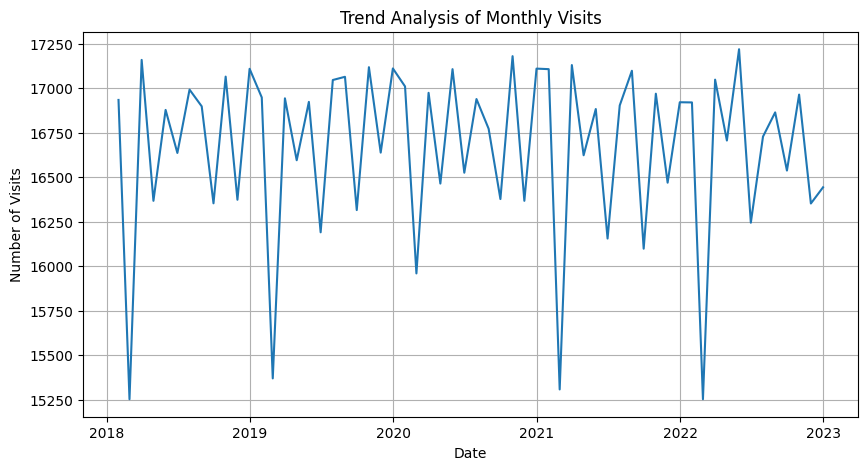

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_resampled_month.index, df_resampled_month['Patient_ID'])
plt.title('Trend Analysis of Monthly Visits')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.grid()
plt.show()

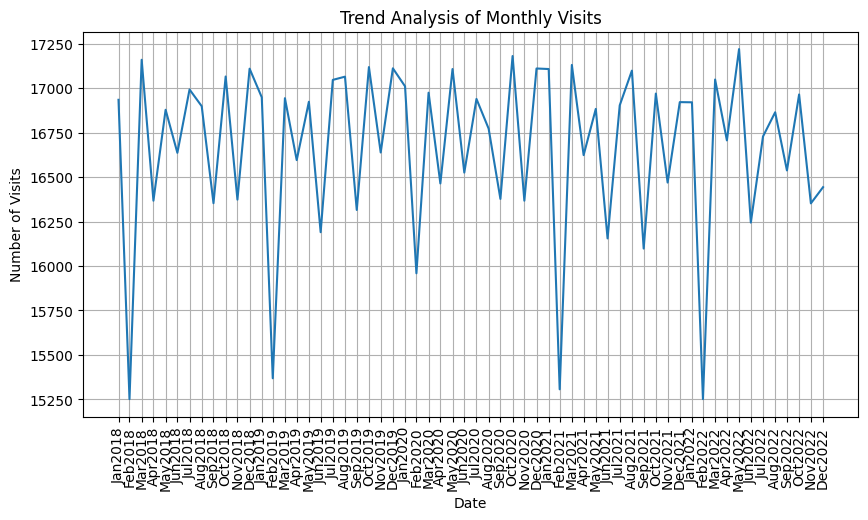

In [ ]:
monthly_ticks = pd.date_range(start=df_resampled_month.index.min(), end=df_resampled_month.index.max(), freq='ME')
monthly_labels = [date.strftime('%b%Y') for date in monthly_ticks]
plt.figure(figsize=(10,5))
plt.plot(df_resampled_month.index, df_resampled_month['Patient_ID'])
plt.title('Trend Analysis of Monthly Visits')
plt.xticks(monthly_ticks, monthly_labels, rotation=90)
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.grid()
plt.show()

Every year in February, there is a sudden drop in patient visits.

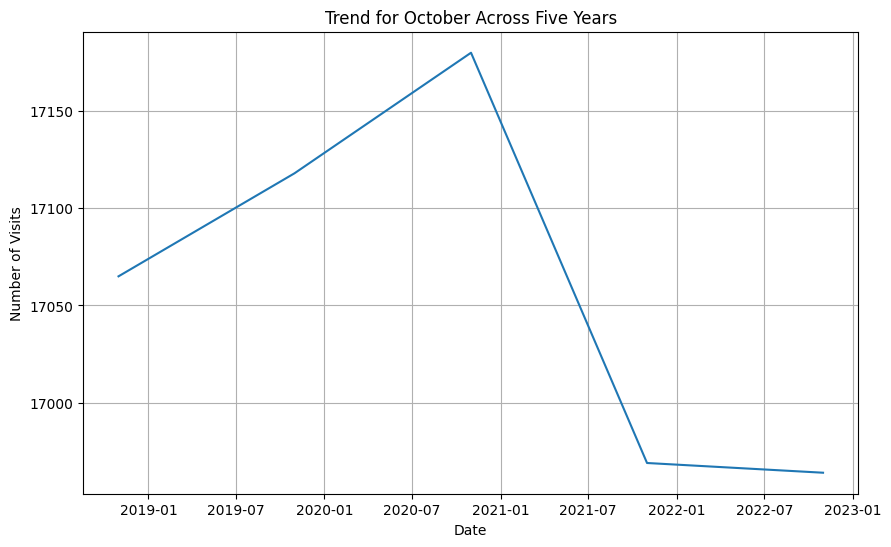

In [ ]:
target_month = 10
df_target_month = df_resampled_month[df_resampled_month.index.month == target_month]
plt.figure(figsize=(10,6))
plt.plot(df_target_month.index, df_target_month['Postcode'])
plt.title(f'Trend for {df_target_month.index[0].strftime('%B')} Across Five Years')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.grid()
plt.show()

### Wait Time Analysis of Patient Visit

In [ ]:
df_visits['Total_Time_Minutes'] = df_visits['Registration_Minutes'] + df_visits['Nursing_Minutes'] + df_visits['Laboratory_Minutes'] + df_visits['Consultation_Minutes'] + df_visits['Pharmacy_Minutes']
df_visits['Total_Time_Hours'] = df_visits['Total_Time_Minutes']/60

In [ ]:
average_total_time_in_hours = df_visits['Total_Time_Hours'].mean()
average_total_time_in_hours

max_time_dept = df_visits[['Registration_Minutes', 'Nursing_Minutes',
       'Laboratory_Minutes', 'Consultation_Minutes', 'Pharmacy_Minutes']].sum().idxmax()
max_time_dept

'Registration_Minutes'

In [ ]:
def dept_wait_time_stats(df, wait_time_col):
  wait_time_mins = df[wait_time_col]
  wait_time_hrs = wait_time_mins/60

  min_time = wait_time_hrs.min()
  max_time = wait_time_hrs.max()
  mean_time = wait_time_hrs.mean()
  median_time = wait_time_hrs.median()
  std_time = wait_time_hrs.std()

  sentence = f"For the department {wait_time_col}, wait time ranges from {min_time:.2f} hours to {max_time:.2f} hours. " \
  f"Average wait time is {mean_time:.2f} hours, with median of {median_time:.2f} hours. The standard deviation is {std_time:.2f}."

  return sentence

In [ ]:
dept_wait_time_stats(df_visits, 'Nursing_Minutes')
dept_wait_time_stats(df_visits, 'Registration_Minutes')
dept_wait_time_stats(df_visits, 'Laboratory_Minutes')

'For the department Laboratory_Minutes, wait time ranges from 0.08 hours to 2.00 hours. Average wait time is 1.04 hours, with median of 1.03 hours. The standard deviation is 0.56.'

In [ ]:
def dept_wait_time_stats(df, dept_name):

  if dept_name not in df.columns:
    return f"Department '{dept_name}' not found."

  wait_time_mins = df[dept_name]
  wait_time_hrs = wait_time_mins/60

  min_time = wait_time_hrs.min()
  max_time = wait_time_hrs.max()
  mean_time = wait_time_hrs.mean()
  median_time = wait_time_hrs.median()
  std_time = wait_time_hrs.std()

  sentence = f"For the department {dept_name}, wait time ranges from {min_time:.2f} hours to {max_time:.2f} hours. " \
  f"Average wait time is {mean_time:.2f} hours, with median of {median_time:.2f} hours. The standard deviation is {std_time:.2f}."

  return sentence

In [ ]:
dept_wait_time_stats(df_visits, 'Registration_Hours')

"Department 'Registration_Hours' not found."

### Wait Time Analysis by Diagnosis

In [ ]:
df_visits.groupby('Diagnosis').agg(Average_Total_Time_Hour=('Total_Time_Hours','mean')).sort_values(by='Average_Total_Time_Hour', ascending=False).reset_index()

,Diagnosis,Average_Total_Time_Hour
0,Backpain,5.217941
1,Ear Infection,5.216439
2,Malaria,5.211591
3,Upper Respiratory Tract Infection,5.211232
4,Hypertension,5.210698
5,Urinary Tract Infection,5.206404
6,Diabetes,5.201405
7,Abdominal pain,5.201262


The average wait time across different diagnoses appears to be relatively consistent. This suggests that the type of illness a patient has does not significantly impact how long they spend at the outpatient clinic on average.

### Effect of Age and Gender on Diagnosis

In [ ]:
total_patients = df_visits.groupby(['Diagnosis','Gender','Age_Range'], observed=True).agg(Total_Patient=('Patient_ID','count')).sort_values(by='Total_Patient', ascending=False).reset_index()
total_patients[total_patients['Total_Patient']>0].nlargest(10, 'Total_Patient')

,Diagnosis,Gender,Age_Range,Total_Patient
0,Malaria,Male,"(0, 10]",13881
1,Abdominal pain,Female,"(0, 10]",13853
2,Upper Respiratory Tract Infection,Male,"(0, 10]",13783
3,Upper Respiratory Tract Infection,Female,"(0, 10]",13731
4,Abdominal pain,Male,"(0, 10]",13726
5,Malaria,Female,"(0, 10]",13709
6,Ear Infection,Female,"(0, 10]",13703
7,Ear Infection,Male,"(0, 10]",13639
8,Malaria,Female,"(10, 20]",12605
9,Malaria,Male,"(10, 20]",12531


In [ ]:
total_patients[total_patients['Total_Patient']>0].nsmallest(10, 'Total_Patient')

,Diagnosis,Gender,Age_Range,Total_Patient
107,Hypertension,Male,"(10, 20]",2854
106,Diabetes,Male,"(10, 20]",2907
105,Urinary Tract Infection,Male,"(10, 20]",2914
104,Hypertension,Female,"(10, 20]",2950
103,Backpain,Female,"(10, 20]",2967
102,Urinary Tract Infection,Female,"(10, 20]",2992
101,Diabetes,Female,"(10, 20]",3067
100,Backpain,Male,"(10, 20]",3069
99,Upper Respiratory Tract Infection,Female,"(80, 90]",5341
98,Upper Respiratory Tract Infection,Male,"(40, 50]",5438


### Correlation Matrix of Numerical Features


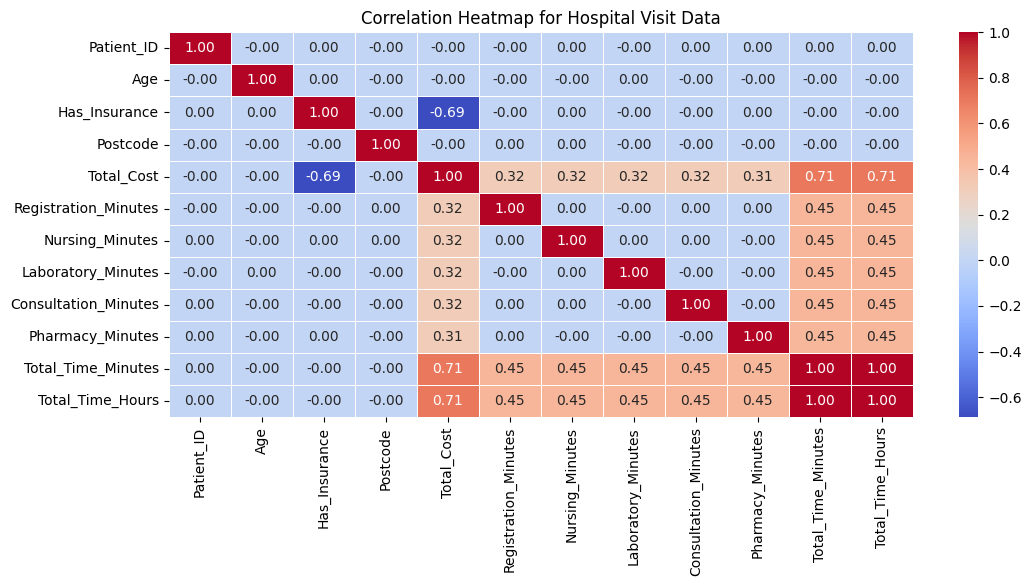

In [ ]:
corr_matrix = df_visits.corr(numeric_only=True)

plt.figure(figsize=(12,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',fmt='.2f', linewidth=0.5)
plt.title('Correlation Heatmap for Hospital Visit Data')
plt.show()

The variable Total_Cost shows a positive correlation with the time spent in Registration, Nursing, Laboratory, Consultation, and Pharmacy. This indicates that the more time a patient spends in these areas, the higher the total cost incurred.
In contrast, Total_Cost has a negative correlation with the variable Has_Insurance, suggesting that patients with insurance tend to incur lower total costs compared to those without insurance.

### Cost and Insurance Analysis of Patient Visit

In [ ]:
avg_cost_by_gender = df_visits.groupby('Gender')['Total_Cost'].mean().reset_index()
avg_cost_by_gender

,Gender,Total_Cost
0,Female,2627.048550
1,Male,2625.128996


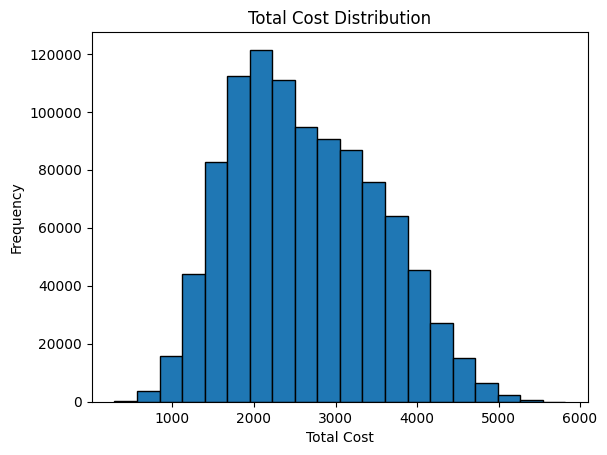

In [ ]:
plt.hist(df_visits['Total_Cost'], bins=20, edgecolor='k')
plt.title('Total Cost Distribution')
plt.xlabel('Total Cost')
plt.ylabel('Frequency')
plt.show()

In [ ]:
avg_cost_with_insurance = df_visits[df_visits['Has_Insurance']==True]['Total_Cost'].mean()
avg_cost_with_insurance

np.float64(1875.4243560527416)

In [ ]:
avg_cost_without_insurance = df_visits[df_visits['Has_Insurance']==False]['Total_Cost'].mean()
avg_cost_without_insurance

np.float64(3126.0332134366477)

In [ ]:
df_visits.reset_index(inplace=True)
df_visits['Visit_Date'] = pd.to_datetime(df_visits['Visit_Date'])
df_visits.set_index('Visit_Date', inplace=True)
annual_total_cost = df_visits['Total_Cost'].resample('YE').sum()

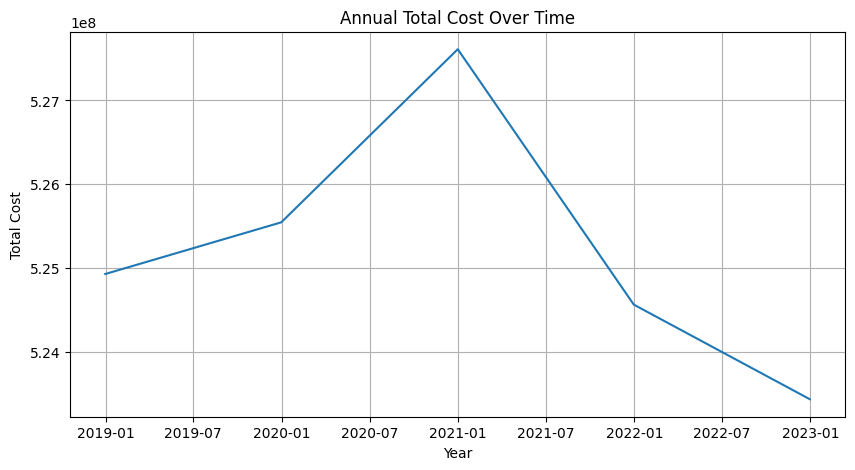

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(annual_total_cost.index,annual_total_cost.values)
plt.title('Annual Total Cost Over Time')
plt.xlabel('Year')
plt.ylabel('Total Cost')
plt.grid()
plt.show()

In [ ]:
df_visits = df_visits.reset_index()
df_visits.set_index('Visit_Date', inplace=True)

In [ ]:
has_insurance_true = df_visits[df_visits['Has_Insurance']==True]['Total_Cost'].resample('YE').sum()
has_insurance_false = df_visits[df_visits['Has_Insurance']==False]['Total_Cost'].resample('YE').sum()

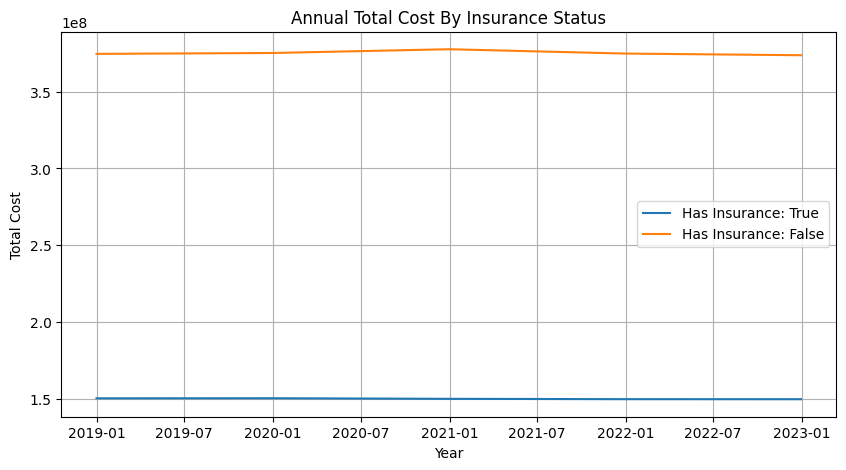

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(has_insurance_true.index,has_insurance_true.values, label='Has Insurance: True')
plt.plot(has_insurance_false.index,has_insurance_false.values, label='Has Insurance: False')
plt.title('Annual Total Cost By Insurance Status')
plt.xlabel('Year')
plt.ylabel('Total Cost')
plt.grid()
plt.legend()
plt.show()

Patients with insurance incurred a lower total cost compared to those without insurance.

### Cost Analysis by Diagnosis

In [ ]:
cost_by_diagnosis = df_visits.groupby('Diagnosis').agg(Total_Cost=('Total_Cost','sum'),
                                   Max_Cost=('Total_Cost','max'),
                                   Min_Cost=('Total_Cost','min'),
                                   Total_Patients=('Patient_ID','count')
                                   ).sort_values(by='Total_Cost', ascending=False).reset_index()

Has_Insurance_True = df_visits[df_visits['Has_Insurance']==True].groupby('Diagnosis').agg(Total_Insured_Patient=('Patient_ID','count')).reset_index()
Has_Insurance_False = df_visits[df_visits['Has_Insurance']==False].groupby('Diagnosis').agg(Total_Not_Insured_Patient=('Patient_ID','count')).reset_index()
patient_by_diagnosis = pd.merge(Has_Insurance_True, Has_Insurance_False, on='Diagnosis')


cost_by_diagnosis = pd.merge(cost_by_diagnosis, patient_by_diagnosis, on='Diagnosis')


cost_by_diagnosis['Total_Insured_Patient_Perc'] = (cost_by_diagnosis['Total_Insured_Patient']/cost_by_diagnosis['Total_Patients']*100).apply(np.ceil)
cost_by_diagnosis['Total_Not_Insured_Patient_Perc'] = (cost_by_diagnosis['Total_Not_Insured_Patient']/cost_by_diagnosis['Total_Patients']*100).apply(np.ceil)

cost_by_diagnosis.drop(columns=['Total_Patients', 'Total_Insured_Patient','Total_Not_Insured_Patient'], inplace=True)

cost_by_diagnosis.sort_values(by='Total_Cost', ascending=False)

,Diagnosis,Total_Cost,Max_Cost,Min_Cost,Total_Insured_Patient_Perc,Total_Not_Insured_Patient_Perc
0,Malaria,509686862.0,5740.0,324.0,40.0,61.0
1,Backpain,380436272.0,5820.0,342.0,40.0,61.0
2,Diabetes,379494094.0,5820.0,336.0,40.0,61.0
3,Hypertension,378313906.0,5710.0,288.0,41.0,60.0
4,Urinary Tract Infection,378151658.0,5680.0,330.0,40.0,61.0
5,Upper Respiratory Tract Infection,340792388.0,5690.0,330.0,41.0,60.0
6,Abdominal pain,129871682.0,5550.0,378.0,40.0,61.0
7,Ear Infection,129341704.0,5640.0,330.0,41.0,60.0


More than 60% of the patients are not insured, which likely leads to higher total costs for them. It is recommended that these patients be encouraged to enroll in a health insurance plan.



In [ ]:
def cost_by_diagnosis(diagnosis_name):
  cost_by_diagnosis = df_visits[df_visits['Diagnosis'] == diagnosis_name]['Total_Cost'].sum()
  max_cost = df_visits[df_visits['Diagnosis'] == diagnosis_name]['Total_Cost'].max()
  min_cost = df_visits[df_visits['Diagnosis'] == diagnosis_name]['Total_Cost'].min()
  avg_cost = df_visits[df_visits['Diagnosis']==diagnosis_name]['Total_Cost'].mean()
  insight = f"The total cost for the diagnosis of {diagnosis_name} is {cost_by_diagnosis}. The cost ranges between {max_cost} and {min_cost}, with an average cost of {avg_cost}."
  return insight

In [ ]:
cost_by_diagnosis('Backpain')

'The total cost for the diagnosis of Backpain is 380436272.0. The cost ranges between 5820.0 and 342.0, with an average cost of 2632.4308360838368.'

## Forecasting

### Total Cost Forecasting

In [ ]:
df_cost_prophet = df_visits.groupby('Visit_Date').agg(Total_Cost=('Total_Cost','sum')).reset_index()
df_cost_prophet.rename(columns={'Visit_Date':'ds', 'Total_Cost':'y'}, inplace=True)
df_cost_prophet['ds'] = pd.to_datetime(df_cost_prophet['ds'])

In [ ]:
model = Prophet()
model.fit(df_cost_prophet)
pred = model.make_future_dataframe(periods=365)
forecast = model.predict(pred)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm_mvwigc/2hwvu6qv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm_mvwigc/xbdvqcw2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73367', 'data', 'file=/tmp/tmpm_mvwigc/2hwvu6qv.json', 'init=/tmp/tmpm_mvwigc/xbdvqcw2.json', 'output', 'file=/tmp/tmpm_mvwigc/prophet_modelql0nee02/prophet_model-20251006132420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 500x400 with 0 Axes>

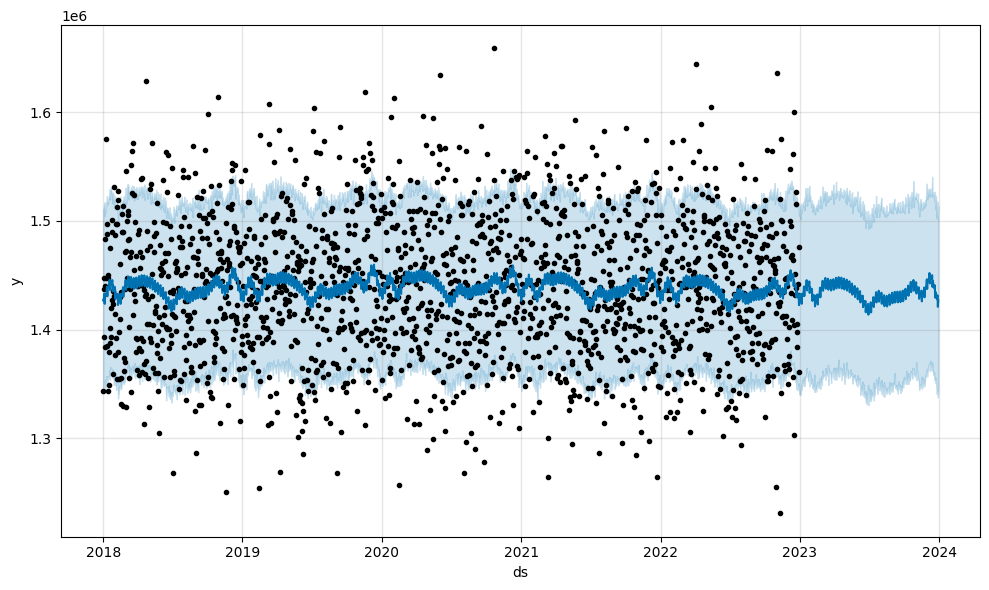

In [ ]:
plt.figure(figsize=(5,4))
fig = model.plot(forecast)
plt.show()

The plot shows the forecasted total cost over time, with the black dots representing the actual historical data and the blue line representing the forecast. The shaded area indicates the confidence interval for the forecast.



<Figure size 500x400 with 0 Axes>

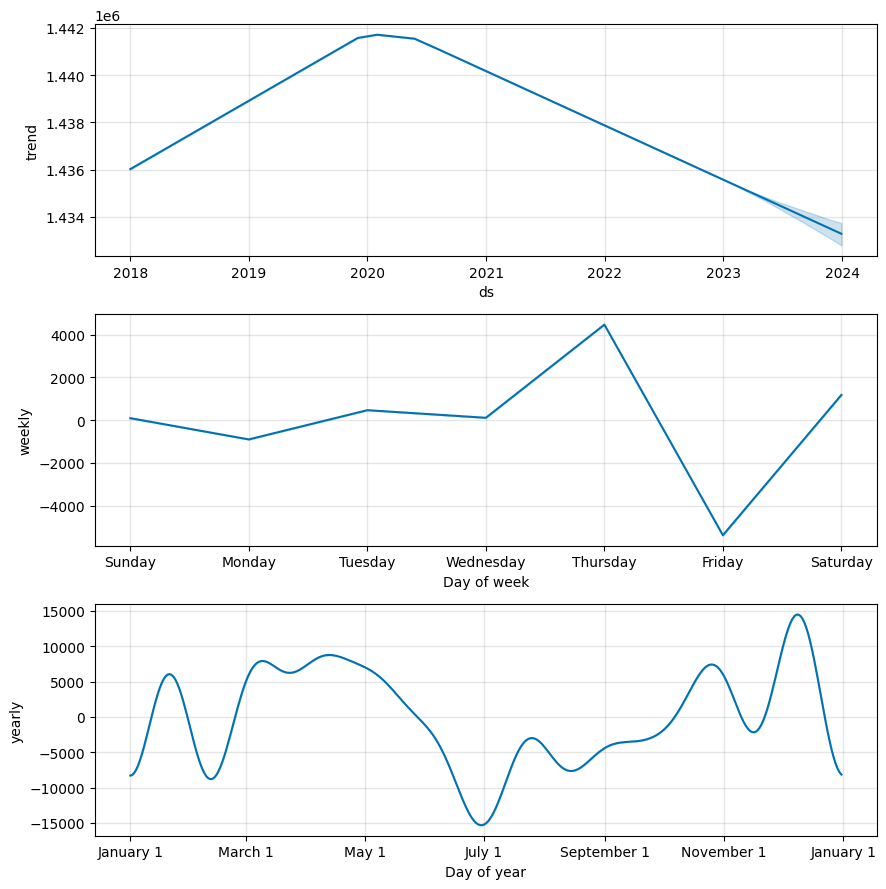

In [ ]:
plt.figure(figsize=(5,4))
fig = model.plot_components(forecast)
plt.show()

**Trend**: This shows the overall long-term direction of the total cost.<br>
**Weekly seasonality**: This reveals any recurring patterns in total cost that occur on a weekly basis. Here the total cost is lowest on Friday.<br>
**Yearly seasonality**: This shows any recurring patterns in total cost that occur on a yearly basis. Here the total cost begin to rise July onwards.<br>

### Wait Time Forecasting

In [ ]:
df_wait_prophet = df_visits.groupby('Visit_Date').agg(Average_Time_Hours=('Total_Time_Hours','mean')).reset_index()
df_wait_prophet.rename(columns={'Visit_Date':'ds', 'Average_Time_Hours':'y'}, inplace=True)
df_wait_prophet['ds'] = pd.to_datetime(df_wait_prophet['ds'])

In [ ]:
model_wait = Prophet()
model_wait.fit(df_wait_prophet)
pred = model_wait.make_future_dataframe(periods=365)
forecast = model_wait.predict(pred)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm_mvwigc/97z3ip6l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm_mvwigc/_h83lnix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42815', 'data', 'file=/tmp/tmpm_mvwigc/97z3ip6l.json', 'init=/tmp/tmpm_mvwigc/_h83lnix.json', 'output', 'file=/tmp/tmpm_mvwigc/prophet_model398k_p_u/prophet_model-20251006132422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 500x400 with 0 Axes>

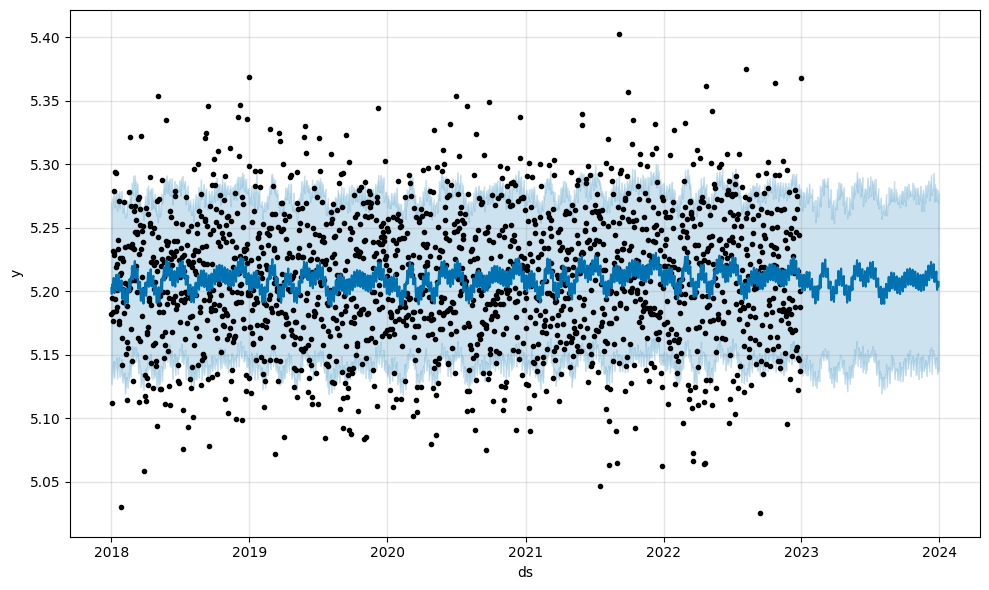

In [ ]:
plt.figure(figsize=(5,4))
fig = model_wait.plot(forecast)
plt.show()

The plot shows the forecasted wait time, with the black dots representing the actual historical data and the blue line representing the forecast. The shaded area indicates the confidence interval for the forecast.



<Figure size 500x400 with 0 Axes>

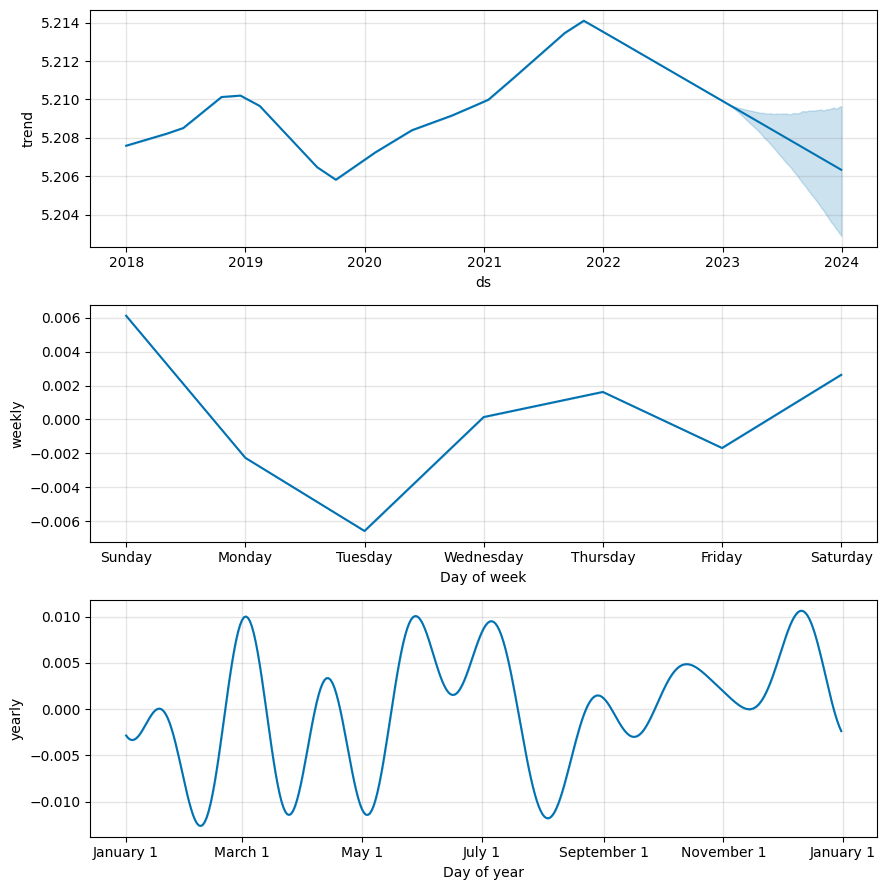

In [ ]:
plt.figure(figsize=(5,4))
fig = model_wait.plot_components(forecast)
plt.show()

**Trend**: This shows the overall long-term direction of the wait time.<br>
**Weekly seasonality**: This reveals any recurring patterns in wait time that occur on a weekly basis. Here the wait time is lowest on Tuesday.<br>
**Yearly seasonality**: This shows any recurring patterns in wait time that occur on a yearly basis. Here the wait time begin to rise July onwards.<br>